# PCA with Supervised Algorithms

## Imports

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.pyplot import matplotlib
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
df = pd.read_csv("Wine.csv")

In [3]:
df.head() # şarapların miktarlarını ve müştelerin verdikleri notları görüyoruz.

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [4]:
df.shape

(178, 14)

In [5]:
df.Customer_Segment.unique()  # 1 kalitesiz 2 vasat 3 kaliteli şarap

array([1, 2, 3])

In [6]:
df.Customer_Segment.value_counts()

2    71
1    59
3    48
Name: Customer_Segment, dtype: int64

AttributeError: ignored

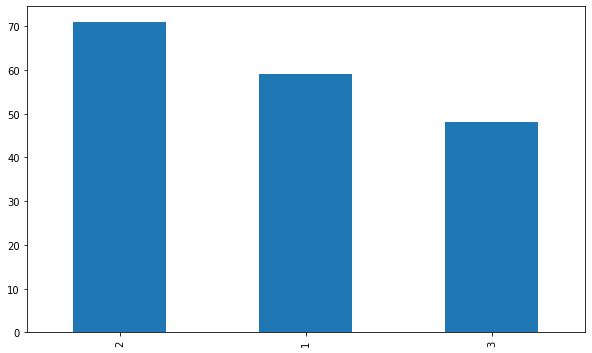

In [58]:
ax = df.Customer_Segment.value_counts().plot.bar()
ax.bar_label(ax.containers[0]);

In [9]:
df.describe()  # outlier problemimiz yok

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,1.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,1.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,1.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,2.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,3.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,3.000000


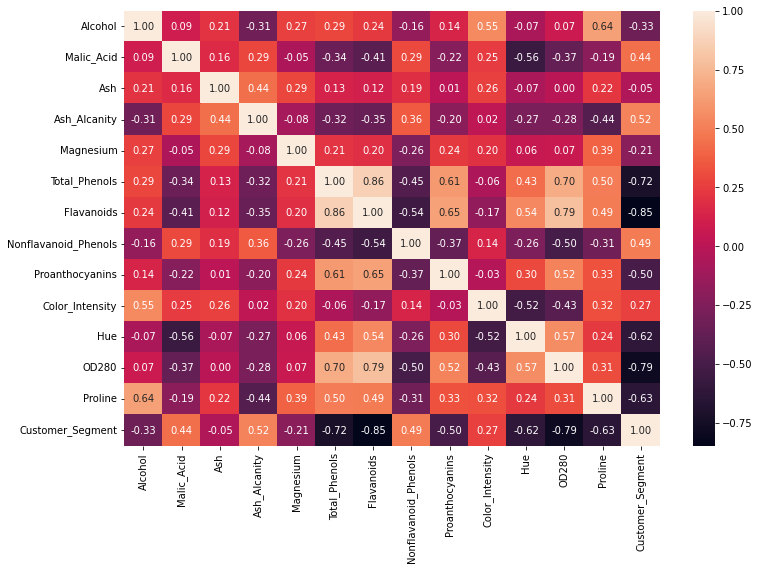

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot = True, fmt=".2f")  
# multicollineraty sorunumuz var ama PCA ile halledeceğiz.

AttributeError: ignored

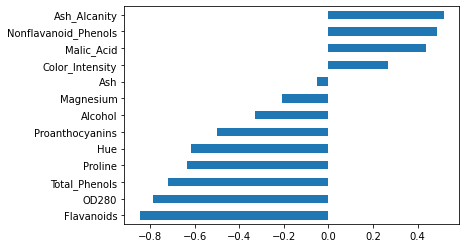

In [11]:
ax = df.corr()["Customer_Segment"][:-1].sort_values().plot(kind="barh")
ax.bar_label(ax.containers[0], fmt="%.2f");

In [12]:
df.isnull().sum().any()

False

## Split the Data

In [13]:
X = df.drop("Customer_Segment", axis = 1)

In [14]:
y = df["Customer_Segment"]

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 0)

## Modeling with Random Forest

Random forest küçük data setlerinde çok başarılı değil fakat yine de kullandık.

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
classifier = RandomForestClassifier(random_state = 0)
classifier.fit(X_train, y_train)
eval_metric(classifier, X_train, y_train, X_test, y_test)

Test_Set
[[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


Train_Set
[[47  0  0]
 [ 0 57  0]
 [ 0  0 38]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



In [20]:
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(random_state = 0)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision_micro','recall_micro','f1_micro'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# eğer bütün skorlarım dengeliyse micro

test_accuracy           0.971905
test_precision_micro    0.971905
test_recall_micro       0.971905
test_f1_micro           0.971905
dtype: float64

In [21]:
classifier.feature_importances_

array([0.12930939, 0.02858818, 0.01005337, 0.02107876, 0.02670528,
       0.04826478, 0.17041694, 0.01237242, 0.01801449, 0.17606478,
       0.06869346, 0.09987653, 0.19056163])

In [22]:
feats = pd.DataFrame(index=df.iloc[:,:-1].columns, data= classifier.feature_importances_, 
                     columns=['Importance'])
imp_feats = feats.sort_values("Importance")
imp_feats

,Importance
Ash,0.010053
Nonflavanoid_Phenols,0.012372
Proanthocyanins,0.018014
Ash_Alcanity,0.021079
Magnesium,0.026705
Malic_Acid,0.028588
Total_Phenols,0.048265
Hue,0.068693
OD280,0.099877
Alcohol,0.129309


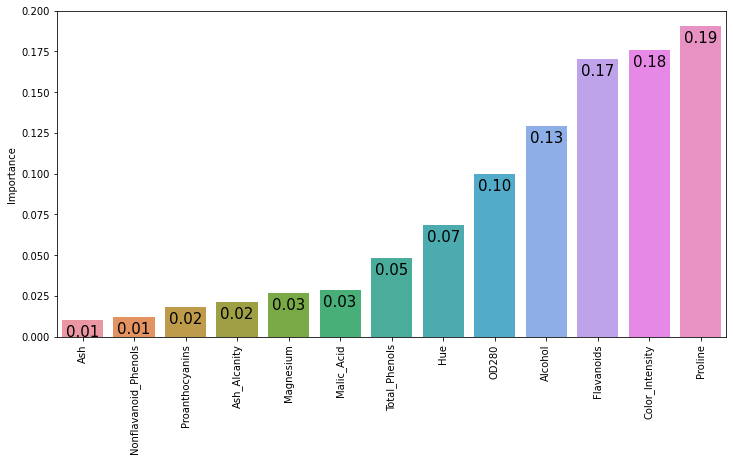

In [23]:
plt.figure(figsize=(12,6))
splot = sns.barplot(data=imp_feats.sort_values('Importance'),x=imp_feats.sort_values('Importance').index,y='Importance')
plt.xticks(rotation=90)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
    
# son 4 değer için salla gitsin diyebiliyoruz random forest sayesinde.

## Remodelling by feature importance

In [24]:
X2 = df[["Proline", "Color_Intensity", "Flavanoids"]]

In [25]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size = 0.2, stratify=y, random_state = 0)

In [26]:
classifier2 = RandomForestClassifier(random_state = 0)
classifier2.fit(X_train2, y_train2)
eval_metric(classifier2, X_train2, y_train2, X_test2, y_test2)

Test_Set
[[12  0  0]
 [ 0 14  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       0.93      1.00      0.97        14
           3       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36


Train_Set
[[47  0  0]
 [ 0 57  0]
 [ 0  0 38]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



In [27]:
model = RandomForestClassifier(random_state = 0)

scores = cross_validate(model, X_train2, y_train2, scoring = ['accuracy', 'precision_micro','recall_micro','f1_micro'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:] # herhangi bir problem yok

test_accuracy           0.957619
test_precision_micro    0.957619
test_recall_micro       0.957619
test_f1_micro           0.957619
dtype: float64

## PCA

## Scaling Data

In [31]:
from sklearn.preprocessing import StandardScaler
# PCA kullanacaksak scale şart ama bu da standardscaler olması lazım sadece.
# neden? --->,covariance matrixlerinin düzgün birşekilde oluşturup birbirine korele olmayan componetler oluştrmak için ekseni doğru seçebilmek için 

In [32]:
scaler = StandardScaler()

In [33]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

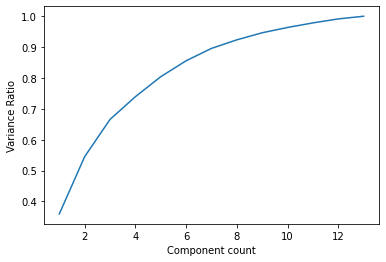

In [34]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_scaled)
x = range(1,14)
plt.plot(x,np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Component count")
plt.ylabel("Variance Ratio");

# Açıklanabilir variance, ne kadar bilgi tuttuğumuzu gösteriyor.

In [35]:
pca = PCA(n_components=13).fit(X_train_scaled) # componentleri train üzerinden alıyoruz.
# fit transform yapmadan once pca.components_ kodu calismiyor.
# Egittikten sonra ozvektorler cikiyor.

In [36]:
my_dict = {"explained_variance":pca.explained_variance_, 
           "explained_variance_ratio":pca.explained_variance_ratio_,
           "cumsum_explained_variance_ratio":pca.explained_variance_ratio_.cumsum()}

In [37]:
df_ev = pd.DataFrame(my_dict, index = range(1,14))
df_ev

,explained_variance,explained_variance_ratio,cumsum_explained_variance_ratio
1,4.706713,0.359505,0.359505
2,2.428244,0.185473,0.544978
3,1.580507,0.120721,0.665699
4,0.964060,0.073636,0.739335
5,0.848632,0.064820,0.804155
6,0.675462,0.051593,0.855748
7,0.524426,0.040056,0.895804
8,0.363173,0.027740,0.923544
9,0.300204,0.022930,0.946474
10,0.224731,0.017165,0.963639


In [40]:
pca = PCA(n_components = 3) # 0.75
# PCA'nın şöyle bir güzelliği var : açıklanabilir varyans oranın ne kadar olduğunu yazdığımızda,
# mesela 0.75

In [43]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  # data leakage olmaması için fit uygulamıyoruz.

In [44]:
df_pca_train = pd.DataFrame(X_train_pca)
df_pca_train = df_pca_train.rename(columns={0:"first_component", 1:"second_component", 2:"third_component"})
df_pca_train.head()

,first_component,second_component,third_component
0,-0.783937,-1.590432,0.568115
1,-1.792083,0.583400,-1.321347
2,2.101051,2.109598,0.790712
3,3.107242,0.448619,-1.057832
4,0.725718,-2.107998,0.588435


In [45]:
df_pca_test=pd.DataFrame(X_test_pca)
df_pca_test = df_pca_test.rename(columns={0:"first_component", 1:"second_component", 2:"third_component"})
df_pca_test.head()

,first_component,second_component,third_component
0,0.510682,-1.703429,0.476175
1,-1.431099,0.675556,0.335034
2,1.517576,-1.098461,-1.110562
3,-2.504356,1.651059,-0.292180
4,-0.335949,-2.097911,-2.503081


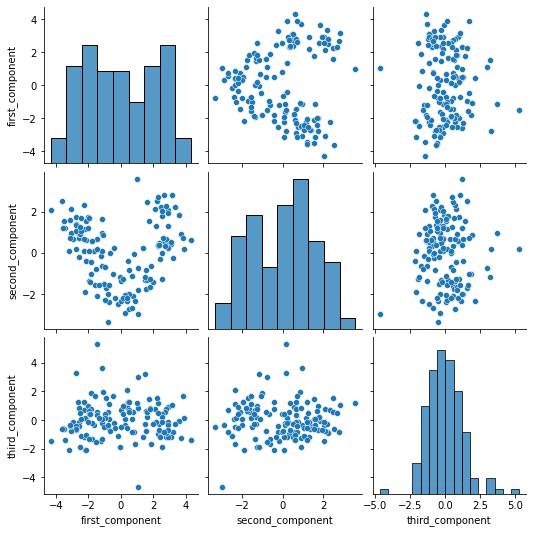

In [46]:
sns.pairplot(df_pca_train)
# random dağılmış corelasion yok

In [47]:
df_pca_train.corr().round()

,first_component,second_component,third_component
first_component,1.0,-0.0,-0.0
second_component,-0.0,1.0,0.0
third_component,-0.0,0.0,1.0


## Modelling after PCA

In [49]:
classifier3 = RandomForestClassifier(random_state = 0) 
classifier3.fit(X_train_pca, y_train)
eval_metric(classifier3, X_train_pca, y_train, X_test_pca, y_test)
# grid search yapmadan önce max_depth ile oynayabiliriz. 
# mesela burada overfit oldu ama aşağıda bunu max_depth ile giderebilriz

Test_Set
[[11  1  0]
 [ 1 13  0]
 [ 0  0 10]]
              precision    recall  f1-score   support

           1       0.92      0.92      0.92        12
           2       0.93      0.93      0.93        14
           3       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.94      0.94      0.94        36


Train_Set
[[47  0  0]
 [ 0 57  0]
 [ 0  0 38]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



In [48]:
classifier3 = RandomForestClassifier(random_state = 0, max_depth=2) # ve overfit giderilmiş.
classifier3.fit(X_train_pca, y_train)
eval_metric(classifier3, X_train_pca, y_train, X_test_pca, y_test)

Test_Set
[[11  1  0]
 [ 1 13  0]
 [ 0  0 10]]
              precision    recall  f1-score   support

           1       0.92      0.92      0.92        12
           2       0.93      0.93      0.93        14
           3       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.94      0.94      0.94        36


Train_Set
[[46  1  0]
 [ 3 53  1]
 [ 0  0 38]]
              precision    recall  f1-score   support

           1       0.94      0.98      0.96        47
           2       0.98      0.93      0.95        57
           3       0.97      1.00      0.99        38

    accuracy                           0.96       142
   macro avg       0.96      0.97      0.97       142
weighted avg       0.97      0.96      0.96       142



In [50]:
from sklearn.pipeline import Pipeline  # pipeline kral. şimdi tüm yaptıklarımızı tek bir satırla yapıyoruz.

In [51]:
operations = [("scaler", StandardScaler()), ("PCA",PCA(n_components=3)),
              ("RF", RandomForestClassifier(random_state = 0, max_depth=2))]

pipe_model = Pipeline(steps=operations)
                                             
scores = cross_validate(pipe_model, X_train, y_train, scoring = ['accuracy', 'precision_micro','recall_micro','f1_micro'], 
                        cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]                                            

test_accuracy           0.957143
test_precision_micro    0.957143
test_recall_micro       0.957143
test_f1_micro           0.957143
dtype: float64

## Interpreting PCA results

Yorumlama kısmı önemli.

In [52]:
scaled_df = pd.DataFrame(X_train_scaled, columns = df.columns[:-1])

In [53]:
combined_df = pd.concat([df_pca_train, scaled_df], axis=1)
correlation = combined_df.corr()
correlation.head()

,first_component,second_component,third_component,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
first_component,1.000000e+00,-8.268266e-17,-8.112231e-17,-0.315917,0.522374,-0.041560,0.457484,-0.297626,-0.858881,-0.910155,0.647516,-0.661573,0.157077,-0.703526,-0.796406,-0.651453
second_component,-8.268266e-17,1.000000e+00,3.609301e-16,0.759174,0.314529,0.481679,-0.033691,0.471424,0.089916,-0.016412,0.122430,0.060781,0.847400,-0.340077,-0.332120,0.556237
third_component,-8.112231e-17,3.609301e-16,1.000000e+00,-0.250287,0.138850,0.764486,0.798863,0.165145,0.186767,0.187314,0.162821,0.177221,-0.138940,0.042489,0.218051,-0.202532
Alcohol,-3.159174e-01,7.591742e-01,-2.502869e-01,1.000000,0.086124,0.201450,-0.315958,0.249971,0.287509,0.224431,-0.089860,0.123973,0.541419,0.040125,0.023660,0.652054
Malic_Acid,5.223736e-01,3.145289e-01,1.388497e-01,0.086124,1.000000,0.123963,0.272138,-0.071824,-0.313270,-0.384919,0.328954,-0.201117,0.203619,-0.534350,-0.365818,-0.216060


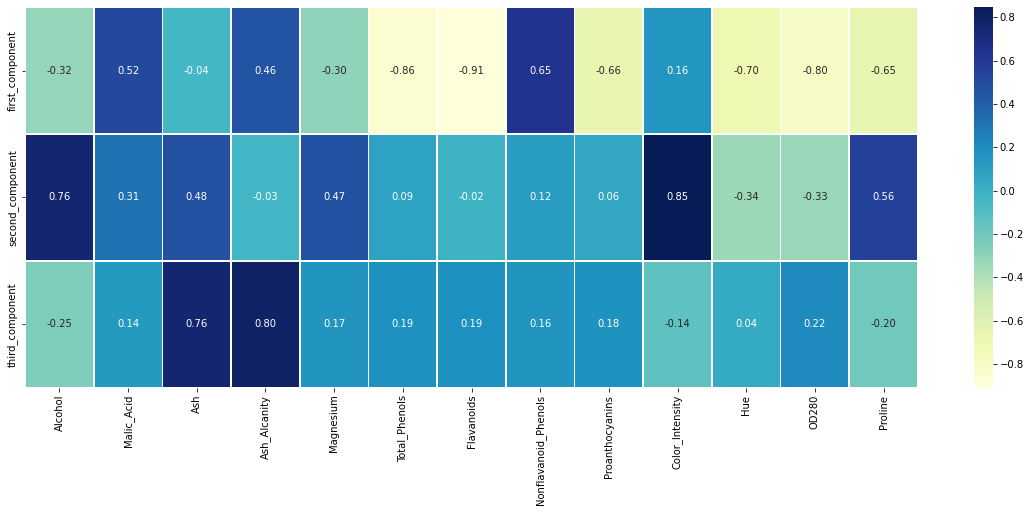

In [54]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(correlation.iloc[:3,3:], cmap='YlGnBu', linewidths=.7, annot=True, fmt='.2f')
plt.show()

# Componentler ile featurelar arası corr'lara bakıyoruz.
# Şuan bir uzman desteği almadan ilk component'in şarap kalitesini ölçmede kullanılan featureların toplamı diyebiliyoruz.
# 1. için kaliteli ve 3. için orta halli, 2. kalitesiz olabilir.

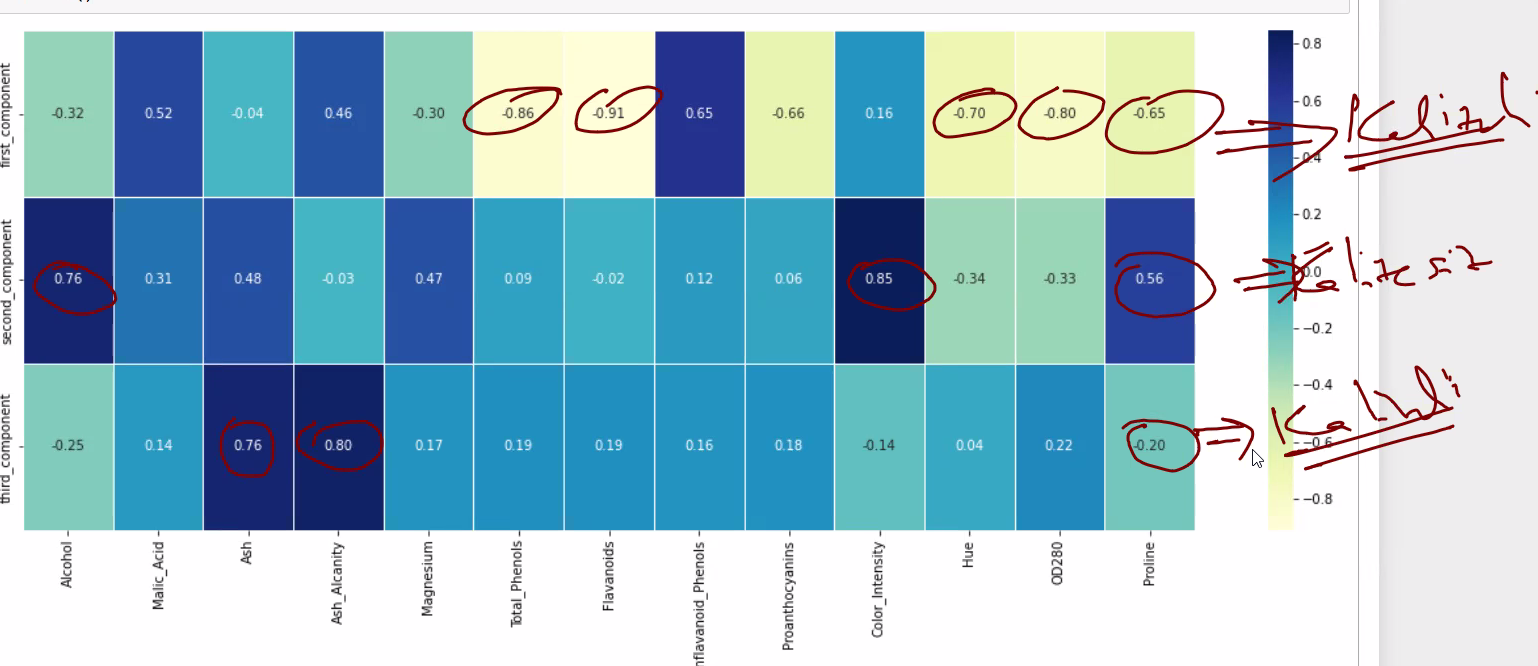

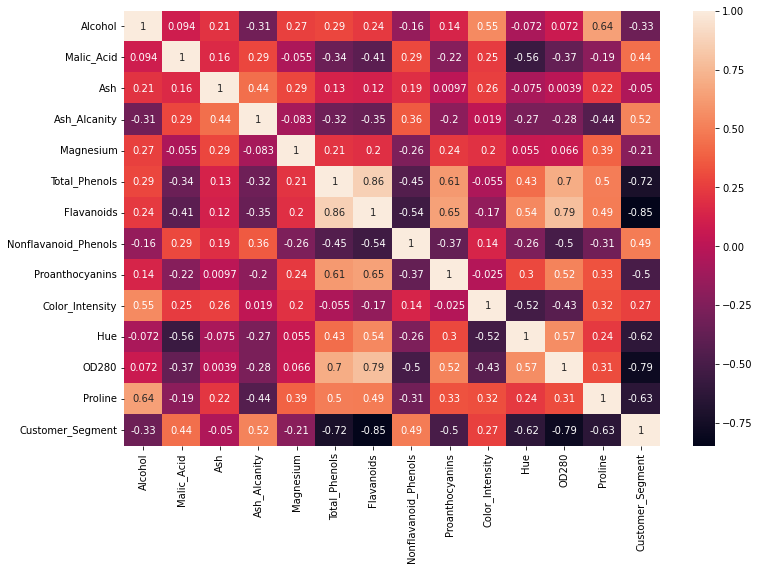

In [55]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot = True)

In [56]:
import plotly.express as px
fig = px.scatter_3d(x=df_pca_train["first_component"], y=df_pca_train["second_component"], 
                    z=df_pca_train["third_component"], color=y_train)
fig.show()
# componentlerimizin birbiriyle güzelce ayrıştıklarını görebiliriz